# Rain Analysis
### Purpose
This notebook will look at volunteer trends for reporting rain, adressing the Github issue #54

### Author: 
Hamza El-Saawy
### Date: 
2020-06-14
### Update Date: 
2020-08-10

### Inputs 
 - `1.3-rec-connecting-fips-ecosystem-data.txt`

### Output Files
None

## Steps or Proceedures in the notebook 
 - Clean the CBC ecological data 
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
n/a

## Notes
the flattened NOAA BigQuery drops the `QFLAG` column, so we cannot drop erroneous data and also does not contain the `WT**` `element` values (which can be used alongside the `PRCP` fields to determin precipitation)

Additionally, there are more permutations of which stations to consider (ie closest in elevation amongst those in the same ecosystem), but that would be combinatorial and there were little indicators that these would have yield better results.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import scipy.stats as stats

In [4]:
import sklearn.metrics as metrics

In [5]:
pd.options.display.max_rows = 250

In [6]:
sns.set(style="darkgrid")

In [7]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

In [8]:
#
# 
#

# drop all stations farther than this threshold (meters)
#  16km ~= 10 mi
DISTANCE_THRESHOLD = 15000

# drop all stations farther than this threshold (meters) in elevation
#  the farthest is 3.5km, with the mean being 70m and median being 23m
ELEVATION_THRESHOLD = 50

# consider stations to consense on a rain value if a fraction of them or more all have the same reading
# at the most abiguous, the fraction will be 0.5, so values are symmetric around 1/2: 0.25 in agreement is the same as 0.75 agreeing on the opposite
AGREEMENT_THRESHOLD = 0.75
AGREEMENT_THRESHOLD = max(AGREEMENT_THRESHOLD, 1 - AGREEMENT_THRESHOLD)

In [9]:
DATA_PATH = '../data/Cloud_Data'
ECO_DATA_PATH =  os.path.join(DATA_PATH, '1.3-rec-connecting-fips-ecosystem-data.txt')

In [10]:
eco_data = pd.read_csv(ECO_DATA_PATH, encoding = "ISO-8859-1", sep="\t", compression = "gzip")

/Users/rcdebaca/.pyenv/versions/funhacks371/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (62,64,65,71,73,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
eco_data.head()

,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,...,block_fips,county_fips,Ecosys_circle,Usgsid_sys_circle,Nlcd_code_circle,Nlcd_circle,Ecosys_station,Usgsid_sys_station,Nlcd_code_station,Nlcd_station
0,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1955,1955-01-01,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1956,1955-12-31,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:

eco_data = eco_data.rename(columns={'circle_name': 'c_name', 'circle_id': 'c_id',
                                    'lat': 'c_lat', 'lon': 'c_lon', 'circle_elev': 'c_elev',
                                    'Ecosys_circle': 'c_ecosys', 'Nlcd_code_circle': 'c_nlcdcode',
                                    'id': 's_id', 'latitude': 's_lat', 'longitude': 's_lon', 'elevation': 's_elev',
                                    'Ecosys_station': 's_ecosys', 'Nlcd_code_station': 's_nlcdcode',})

In [13]:
# Observe the Size of the data frame
eco_data.shape

(756378, 78)

In [14]:
# Observe the number of unique circles in the dataframe 
eco_data['ui'].nunique()

80765

In [15]:
# Drop all the other data that wont be needed
prcp_data = eco_data.loc[:, ['count_date', 'c_name', 'ui','country_state', 'c_id', 'c_lat', 'c_lon',
                              'am_rain', 'pm_rain', 'c_elev', 'c_ecosys', 'c_nlcdcode',
                              's_id', 's_lat', 's_lon', 's_elev', 's_ecosys', 's_nlcdcode','precipitation_value',
                             ]]

## Data Prep

#### Stations Reporting Rain 
A ghcn station will report rain by the precipitation value. 

In [16]:
# Create the field s_rain which is True if the row has a value of precipitation 
# greater than 0 (an indicator that it rained) and is NA otherwise

# precipitation is GHCN's measure of rain fall, in mm
# pd.NA preserved int-ness of bools, so they are not converted to floats, and supports three-valued (kleene) logic
prcp_data['s_rain'] = np.where(prcp_data.precipitation_value.isna(), pd.NA, prcp_data.precipitation_value > 0)

In [17]:
prcp_data[['precipitation_value', 's_rain']].head()

,precipitation_value,s_rain
0,180.0,True
1,290.0,True
2,NaN,<NA>
3,NaN,<NA>
4,NaN,<NA>


#### Volunteer records on rain data 

CBC volunteers record the rain in two fields am_rain and pm_rain. 

`[am|pm]_rain` are strings containing `1`:`4`, for heavy, light, none, or unknow rain, respectively.  
If the string contains `4`, then -- regardless of observations in that string (e.g. `2,4`) -- it will be marked as `NaN`  
If the string contains either `1` or `2` in the am or pm, then there was precipitation that day.   
If both am and pm are `3`, then there was no precipitation that day.  
Else, we mark `nan`

In [18]:
# Mark circles with '4' as pd.NA and if the circle is na mark it as pd.NA
for c in ['am_rain', 'pm_rain']:
    prcp_data.loc[prcp_data[c].isna(), c] = pd.NA
    prcp_data.loc[prcp_data[c].str.contains('4', na=False), c] = pd.NA

In [19]:
# Use Regex to find the rows that contain a "1" and/or "2". 
# If those values are recorded set the value of c_rain to True
# If a "3" is recorded set c_rain to False

prcp_data['c_rain'] = pd.NA

prcp_data.loc[(prcp_data.am_rain.str.contains('[12]', na=False) | prcp_data.pm_rain.str.contains('[12]', na=False)), 'c_rain'] = True
prcp_data.loc[((prcp_data.am_rain == '3') & (prcp_data.pm_rain == '3')), 'c_rain'] = False



## Comparing stations and circles
1. Calulate the distance between the station and the circle. Field is 'distance' 
2. Calulate the absolute change in elivation between the station and the circle. Field is 'd_elev'
3. Calulate if station and circle share ecosystem. Fields 'same_ecosys' and 'same_nlcd'

In [20]:
# Calulate the distace between the station and the circle using the haversine formula 
# (haversine calulates the distance on a globe)
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)


In [21]:
# Calulcate the absolute difference in Elivation between the circle and the station
prcp_data['d_elev'] = np.abs(prcp_data.s_elev - prcp_data.c_elev)

In [22]:
# convert to int array to get nullable boolean arrays
#  https://pandas.pydata.org/pandas-docs/stable/user_guide/boolean.html#kleene-logical-operations
prcp_data['same_ecosys'] = prcp_data.c_ecosys.astype('Int64') == prcp_data.s_ecosys.astype('Int64')
prcp_data['same_nlcd'] = prcp_data.c_nlcdcode.astype('Int64') == prcp_data.s_nlcdcode.astype('Int64')

## Apply Data Limits on Elevation and Distance and Prep for Analysis 
1. Drop rows where the circle and the station are too far away from each other in either distance or elivation
2. Remove columns we dont need
3. Sort the dataset by circle then station

In [23]:
# drop everything outside of the distance or elevation threshold
prcp_data.drop(prcp_data[prcp_data.distance > DISTANCE_THRESHOLD].index, inplace=True)
prcp_data.drop(prcp_data[prcp_data.d_elev > ELEVATION_THRESHOLD].index, inplace=True)

In [24]:
# once again dump excess data
prcp_data.drop(columns=['am_rain', 'pm_rain','c_elev', 'c_ecosys', 'c_nlcdcode', 
                        's_elev', 's_ecosys', 's_nlcdcode','precipitation_value',], inplace=True)

In [25]:
# isolate only the circle specific volunteer data
circle_obs = prcp_data[['count_date', 'c_name', 'ui','country_state', 
                        'c_id', 'c_lat', 'c_lon','c_rain']].groupby(['c_id', 'count_date']).agg('first')

In [26]:
# sort by circle then station information
prcp_data = prcp_data.set_index(['c_id', 'count_date', 's_id']).sort_index()

In [27]:
prcp_data.head(100)

c_name                     ui  \
c_id    count_date s_id                                                 
87ymwsn 1968-12-26 USC00519130  Kaua'i: Waimea  22.0833-159.6667_1969   
87ysunb 1971-12-27 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00518217  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00518570  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00518573  Kaua'i: Lihu'e  21.9667-159.4333_1972   
        1972-12-17 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00518217  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00518570  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00518573  Kaua'i: Lihu'e  21.9667-159.4333_1973   
        1973-12-16 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00518217  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00518570  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00518573  Kaua'i: Lihu'e  21.9667-159.4333_1974   
        1974-12-15 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00518217  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00518570  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00518573  Kaua'i: Lihu'e  21.9667-159.4333_1975   
        1976-01-04 US1HIK

In [28]:
prcp_data.shape

(412105, 13)

# Rain Analysis

In [29]:
g = prcp_data.groupby(level=['c_id', 'count_date'])

In [30]:
g.head()

c_name                        ui  \
c_id    count_date s_id                                                     
87ymwsn 1968-12-26 USC00519130   Kaua'i: Waimea     22.0833-159.6667_1969   
87ysunb 1971-12-27 US1HIKI0004   Kaua'i: Lihu'e     21.9667-159.4333_1972   
                   US1HIKI0014   Kaua'i: Lihu'e     21.9667-159.4333_1972   
                   US1HIKI0018   Kaua'i: Lihu'e     21.9667-159.4333_1972   
                   USC00510006   Kaua'i: Lihu'e     21.9667-159.4333_1972   
...                                         ...                       ...   
zcpkrwz 1979-12-18 USW00045702  Amchitka Island  51.409713179.284881_1980   
        1992-12-20 USC00500252  Amchitka Island  51.409713179.284881_1993   
                   USW00045702  Amchitka Island  51.409713179.284881_1993   
        1993-12-28 USC00500252  Amchitka Island  51.409713179.284881_1994   
                   USW00045702  Amchitka Island  51.409713179.284881_1994   

                               country_state      c_lat       c_lon    s_lat  \
c_id    count_date s_id                                                        
87ymwsn 1968-12-26 USC00519130         US-HI  22.083300 -159.666700  22.1167   
87ysunb 1971-12-27 US1HIKI0004         US-HI  21.966700 -159.433300  21.9249   
                   US1HIKI0014         US-HI  21.966700 -159.433300  21.9055   
                   US1HIKI0018         US-HI  21.966700 -159.433300  21.9075   
                   USC00510006         US-HI  21.966700 -159.433300  21.9500   
...                                      ...        ...         ...      ...   
zcpkrwz 1979-12-18 USW00045702         US-AK  51.409713  179.284881  51.3833   
        1992-12-20 USC00500252         US-AK  51.409713  179.284881  51.3833   
                   USW00045702         US-AK  51.409713  179.284881  51.3833   
        1993-12-28 USC00500252         US-AK  51.409713  179.284881  51.3833   
                   USW00045702         US-AK  51.409713  179.284881  51.3833   

                                   s_lon s_rain c_rain      distance  d_elev  \
c_id    count_date s_id                                                        
87ymwsn 1968-12-26 USC00519130 -159.6167   <NA>  False   6352.278644   36.16   
87ysunb 1971-12-27 US1HIKI0004 -159.4983   <NA>   True   8159.889753   43.84   
                   US1HIKI0014 -159.5150   <NA>   True  10834.614107   11.26   
                   US1HIKI0018 -159.5181   <NA>   True  10950.027151   17.34   
                   USC00510006 -159.4333   <NA>   True   1857.479921   35.96   
...                                  ...    ...    ...           ...     ...   
zcpkrwz 1979-12-18 USW00045702  179.2500   <NA>  False   3806.612762     NaN   
        1992-12-20 USC00500252  179.2833   <NA>   <NA>   2939.869435     NaN   
                   USW00045702  179.2500   <NA>   <NA>   3806.612762     NaN   
        1993-12-28 USC00500252  179.2833   <NA>   <NA>   2939.869435     NaN   
                   USW00045702  179.2500   <NA>   <NA>   3806.612762     NaN   

                                same_ecosys  same_nlcd  
c_id    count_date s_id                                 
87ymwsn 1968-12-26 USC00519130         <NA>       <NA>  
87ysunb 1971-12-27 US1HIKI0004         <NA>       <NA>  
                   US1HIKI0014         <NA>       <NA>  
                   US1HIKI0018         <NA>       <NA>  
                   USC00510006         <NA>       <NA>  
...                                     ...        ...  
zcpkrwz 1979-12-18 USW00045702         <NA>       <NA>  
        1992-12-20 USC00500252         <NA>       <NA>  
                   USW00045702         <NA>       <NA>  
        1993-12-28 USC00500252         <NA>       <NA>  
                   USW00045702         <NA>       <NA>  

[218997 rows x 13 columns]

In [31]:
def rain_calc(dfg):
    is_na = dfg.s_rain.isna()

    # there can be weirdness with boolean not being promoted to ints, so add zero
    num = dfg.s_rain.size + 0
    num_notna = dfg.s_rain.count() + 0
    num_true = dfg.s_rain.sum() + 0
    
    e = dfg.loc[dfg.same_ecosys, 's_rain']
    e_num = e.size + 0
    e_num_notna = e.count() + 0
    e_num_true = e.sum() + 0
    
    n = dfg.loc[dfg.same_nlcd, 's_rain']
    n_num = n.size + 0
    n_num_notna = n.count() + 0
    n_num_true = n.sum() + 0
    
    # havent figured out how to inlinse this yet ...
    lowest_id = dfg.d_elev.idxmin() if (num > 0) else np.NaN
    lowest_id_na = dfg.loc[~is_na, 'd_elev'].idxmin() if (num_notna > 0) else np.NaN
    
    return pd.Series({
        'num' : num,
        'num_notna' : num_notna,
        'num_true' : num_true,
        
        'e_num' : e_num,
        'e_num_notna' : e_num_notna,
        'e_num_true' : e_num_true,
        
        'n_num' : n_num,
        'n_num_notna' : n_num_notna,
        'n_num_true' : n_num_true,

        'p' : num_true / num_notna if (num_notna > 0) else np.NaN,
        'e_p' : e_num_true / e_num_notna if (e_num_notna > 0) else np.NaN,
        'n_p' : n_num_true / n_num_notna if (n_num_notna > 0) else np.NaN,
        
        'rain_closest' : dfg.loc[dfg.distance.idxmin(), 's_rain'] if (num > 0) else pd.NA,
        'rain_closest_notna' : dfg.loc[dfg.loc[~is_na, 'distance'].idxmin(), 's_rain'] if (num_notna > 0) else pd.NA,
        
        'rain_lowest' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 's_rain'],
        'rain_lowest_notna' : pd.NA if pd.isna(lowest_id_na) else dfg.loc[lowest_id_na, 's_rain'],
    })


In [32]:
circle_data = g.apply(rain_calc)

# The new fields used for Analysis
num - The number of stations for a circle for a count date

num_notna - The number of stations that are not null for their rain measurment 

num_true - The number of stations that reported true for rain

The next sections for "e_" and "n_" are the same as abouve, except e is only stations for a circle that
are in the same ecosystem and n is stations with the same nlcd code.

p - The proportion of stations that reported rain for a circle


In [33]:
circle_data.head()

num  num_notna  num_true  e_num  e_num_notna  e_num_true  \
c_id    count_date                                                             
87ymwsn 1968-12-26    1          0         0      0            0           0   
87ysunb 1971-12-27   13          0         0      0            0           0   
        1972-12-17   13          0         0      0            0           0   
        1973-12-16   13          2         0      0            0           0   
        1974-12-15   13          0         0      0            0           0   

                    n_num  n_num_notna  n_num_true    p  e_p  n_p  \
c_id    count_date                                                  
87ymwsn 1968-12-26      0            0           0  NaN  NaN  NaN   
87ysunb 1971-12-27      0            0           0  NaN  NaN  NaN   
        1972-12-17      0            0           0  NaN  NaN  NaN   
        1973-12-16      0            0           0  0.0  NaN  NaN   
        1974-12-15      0            0           0  NaN  NaN  NaN   

                   rain_closest rain_closest_notna rain_lowest  \
c_id    count_date                                               
87ymwsn 1968-12-26         <NA>               <NA>        <NA>   
87ysunb 1971-12-27         <NA>               <NA>        <NA>   
        1972-12-17         <NA>               <NA>        <NA>   
        1973-12-16         <NA>              False        <NA>   
        1974-12-15         <NA>               <NA>        <NA>   

                   rain_lowest_notna  
c_id    count_date                    
87ymwsn 1968-12-26              <NA>  
87ysunb 1971-12-27              <NA>  
        1972-12-17              <NA>  
        1973-12-16             False  
        1974-12-15              <NA>

In [34]:
# Add in the circles details (Name, State, Lat, Lon)
circle_data = circle_obs.join(circle_data)

# Determine if there is Consensus amoung a Circle's Reference Stations
Using the AGREEMENT_THRESHOLD set at the top of the notebook, determine if the there are enough stations for
a circle agree that it rained based on that agreement threshold.

Do this for all stations and stations within the same ecosys and nlcd code 

In [35]:
# If the stations couldnt agree (p ∈ [1-AGREEMENT_THRESHOLD, AGREEMENT_THRESHOLD]) or p is NaN, set the consenus to NaN as well
circle_data['consensus'] = np.where(((circle_data.p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.p <= AGREEMENT_THRESHOLD)) | circle_data.p.isna(), 
                                     pd.NA, circle_data.p >= AGREEMENT_THRESHOLD)

circle_data['e_consensus'] = np.where(((circle_data.e_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.e_p <= AGREEMENT_THRESHOLD)) | circle_data.e_p.isna(), 
                                     pd.NA, circle_data.e_p >= AGREEMENT_THRESHOLD)

circle_data['n_consensus'] = np.where(((circle_data.n_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.n_p <= AGREEMENT_THRESHOLD)) | circle_data.n_p.isna(), 
                                     pd.NA, circle_data.n_p >= AGREEMENT_THRESHOLD)

In [36]:
for c in ['consensus', 'e_consensus', 'n_consensus', 'rain_closest', 'rain_closest_notna', 'rain_lowest', 'rain_lowest_notna']:
    circle_data[c] = circle_data[c].astype('boolean')

In [37]:
circle_data.head()

c_name                     ui country_state  \
c_id    count_date                                                        
87ymwsn 1968-12-26  Kaua'i: Waimea  22.0833-159.6667_1969         US-HI   
87ysunb 1971-12-27  Kaua'i: Lihu'e  21.9667-159.4333_1972         US-HI   
        1972-12-17  Kaua'i: Lihu'e  21.9667-159.4333_1973         US-HI   
        1973-12-16  Kaua'i: Lihu'e  21.9667-159.4333_1974         US-HI   
        1974-12-15  Kaua'i: Lihu'e  21.9667-159.4333_1975         US-HI   

                      c_lat     c_lon c_rain  num  num_notna  num_true  e_num  \
c_id    count_date                                                              
87ymwsn 1968-12-26  22.0833 -159.6667  False    1          0         0      0   
87ysunb 1971-12-27  21.9667 -159.4333   True   13          0         0      0   
        1972-12-17  21.9667 -159.4333   True   13          0         0      0   
        1973-12-16  21.9667 -159.4333    NaN   13          2         0      0   
        1974-12-15  21.9667 -159.4333   True   13          0         0      0   

                    ...    p  e_p  n_p  rain_closest  rain_closest_notna  \
c_id    count_date  ...                                                    
87ymwsn 1968-12-26  ...  NaN  NaN  NaN          <NA>                <NA>   
87ysunb 1971-12-27  ...  NaN  NaN  NaN          <NA>                <NA>   
        1972-12-17  ...  NaN  NaN  NaN          <NA>                <NA>   
        1973-12-16  ...  0.0  NaN  NaN          <NA>               False   
        1974-12-15  ...  NaN  NaN  NaN          <NA>                <NA>   

                    rain_lowest  rain_lowest_notna  consensus  e_consensus  \
c_id    count_date                                                           
87ymwsn 1968-12-26         <NA>               <NA>       <NA>         <NA>   
87ysunb 1971-12-27         <NA>               <NA>       <NA>         <NA>   
        1972-12-17         <NA>               <NA>       <NA>         <NA>   
        1973-12-16         <NA>              False      False         <NA>   
        1974-12-15         <NA>               <NA>       <NA>         <NA>   

                    n_consensus  
c_id    count_date               
87ymwsn 1968-12-26         <NA>  
87ysunb 1971-12-27         <NA>  
        1972-12-17         <NA>  
        1973-12-16         <NA>  
        1974-12-15         <NA>  

[5 rows x 25 columns]

In [38]:
# Count the number of circles we have 
circle_data['ui'].nunique()

68390

# Analysis
## First examine the top level stats.

### The number of stations per circle

In [39]:
circle_data.num.describe()

count    68390.000000
mean         6.025808
std          7.684488
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        101.000000
Name: num, dtype: float64

Text(0.5, 0, 'number of stations')

2020-09-22 12:20:46,472 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
2020-09-22 12:20:46,473 findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:46,475 findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:46,476 findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05
2020-09-22 12:20:46,496 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2020-09-22 12:20:46,500 findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2020-09-22 12:20:46,506 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 3.05
2020-09-22 12:20:46,507 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2020-09-22 12:20:46,508 findfont: score

2020-09-22 12:20:46,887 findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10.335
2020-09-22 12:20:46,891 findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
2020-09-22 12:20:46,895 findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:46,897 findfont: score(<Font 'Noto Sans Lepcha' (NotoSansLepcha-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:46,900 findfont: score(<Font 'Noto Sans Old Persian' (NotoSansOldPersian-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:46,903 findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:46,905 findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:46,911 findfont: score(<Font 'Raanana' (Raanana.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12

2020-09-22 12:20:47,154 findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal regular normal>) = 10.05
2020-09-22 12:20:47,158 findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:47,160 findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25
2020-09-22 12:20:47,163 findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal medium normal>) = 10.145
2020-09-22 12:20:47,167 findfont: score(<Font 'Serto Batnan' (SyrCOMBatnan.otf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,170 findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:47,172 findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,174 findfont: score(<Font 'Noto Sans Syriac' (NotoSansSyriac-Regular.ttf) normal normal regular normal>) = 10.05
2

2020-09-22 12:20:47,350 findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,354 findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05
2020-09-22 12:20:47,358 findfont: score(<Font 'Noto Sans Old Turkic' (NotoSansOldTurkic-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:47,361 findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
2020-09-22 12:20:47,366 findfont: score(<Font 'Luxi Sans' (luxisr.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:47,369 findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal regular normal>) = 11.05
2020-09-22 12:20:47,372 findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal book normal>) = 10.05
2020-09-22 12:20:47,377 findfont: score(<Font 'Andale Mono' (Andale Mono.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,380 fin

2020-09-22 12:20:47,618 findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,619 findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
2020-09-22 12:20:47,621 findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.24
2020-09-22 12:20:47,622 findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,625 findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.otf) normal normal 700 normal>) = 10.335
2020-09-22 12:20:47,642 findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44
2020-09-22 12:20:47,645 findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,646 findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,648 findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic

2020-09-22 12:20:47,900 findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,905 findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525
2020-09-22 12:20:47,907 findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,910 findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05
2020-09-22 12:20:47,913 findfont: score(<Font 'Bitstream Vera Sans' (Vera.ttf) normal normal 400 normal>) = 6.05
2020-09-22 12:20:47,914 findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal regular condensed>) = 10.25
2020-09-22 12:20:47,915 findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,917 findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:47,922 findfont: sco

2020-09-22 12:20:48,141 findfont: score(<Font 'Noto Sans Oriya' (NotoSansOriya.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:48,144 findfont: score(<Font 'Marion' (Marion.ttc) normal normal regular normal>) = 10.05
2020-09-22 12:20:48,149 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('/System/Library/Fonts/Supplemental/Arial.ttf') with score of 0.050000.
2020-09-22 12:20:48,199 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2020-09-22 12:20:48,231 findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:48,234 findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:48,246 findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05
2020-09-22 12:20:48,250 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic no

2020-09-22 12:20:48,504 findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
2020-09-22 12:20:48,506 findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:48,507 findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:48,512 findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:48,515 findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10.335
2020-09-22 12:20:48,518 findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
2020-09-22 12:20:48,521 findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:48,522 findfont: score(<Font 'Noto Sans Lepcha' (NotoSansLepcha-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:48,524 findfont: sco

2020-09-22 12:20:49,416 findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:49,420 findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 10.335
2020-09-22 12:20:49,423 findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:49,425 findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:49,426 findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal regular normal>) = 10.05
2020-09-22 12:20:49,427 findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:49,434 findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25
2020-09-22 12:20:49,437 findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal medium normal>) = 10.145
2020-09-22 12:20:49,438 findfont: 

2020-09-22 12:20:49,655 findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:49,658 findfont: score(<Font 'Luxi Mono' (luximri.ttf) oblique normal 400 normal>) = 11.05
2020-09-22 12:20:49,660 findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:49,663 findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:49,667 findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05
2020-09-22 12:20:49,671 findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:49,677 findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05
2020-09-22 12:20:49,681 findfont: score(<Font 'Noto Sans Old Turkic' (NotoSansOldTurkic-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:49,685 findfon

2020-09-22 12:20:49,927 findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:49,929 findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal regular normal>) = 10.05
2020-09-22 12:20:49,933 findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:49,935 findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:49,938 findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:49,941 findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:49,951 findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:49,957 findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
2020-09-22 12:20:49,958 findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal

2020-09-22 12:20:50,806 findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
2020-09-22 12:20:50,810 findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:50,817 findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 10.335
2020-09-22 12:20:50,820 findfont: score(<Font 'Estrangelo Midyat' (SyrCOMMidyat.otf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:50,823 findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:50,825 findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:50,827 findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 400 normal>) = 10.05
2020-09-22 12:20:50,828 findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:50,830 findfont: score(<Font 'Noto Sans Myanmar' (Not

2020-09-22 12:20:51,070 findfont: score(<Font 'Sana' (Sana.ttc) normal normal regular normal>) = 10.05
2020-09-22 12:20:51,073 findfont: score(<Font 'Noto Sans Tai Viet' (NotoSansTaiViet-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:51,074 findfont: score(<Font 'Noto Sans Brahmi' (NotoSansBrahmi-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-22 12:20:51,076 findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:51,079 findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal roman normal>) = 10.145
2020-09-22 12:20:51,081 findfont: score(<Font 'Kohinoor Gujarati' (KohinoorGujarati.ttc) normal normal bold normal>) = 10.335
2020-09-22 12:20:51,084 findfont: score(<Font 'Times New Roman' (Times New Roman Bold.ttf) normal normal 700 normal>) = 10.335
2020-09-22 12:20:51,087 findfont: score(<Font 'Noto Sans Oriya' (NotoSansOriya.ttc) normal normal 400 normal>) = 10.05
2020-09-22 12:20:51,0

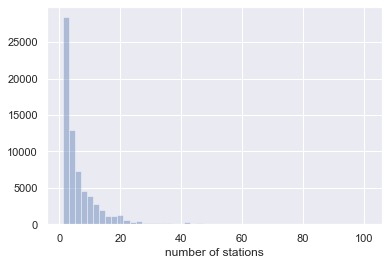

In [40]:
sns.distplot(circle_data.num, kde=False).set_xlabel("number of stations")

### The number of stations that reported Rain data (non-NaN stations per circle)

In [41]:
circle_data.num_notna.describe()

count    68390.000000
mean         1.053180
std          1.383659
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         33.000000
Name: num_notna, dtype: float64

Text(0.5, 0, 'Number of Stations with Rain Data')

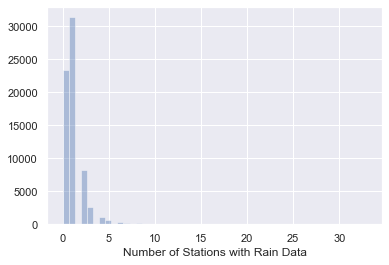

In [42]:
sns.distplot(circle_data.num_notna, kde=False).set_xlabel("Number of Stations with Rain Data")

## Missing Stations

Text(0.5, 1.0, 'cumulative percent of stations missing')

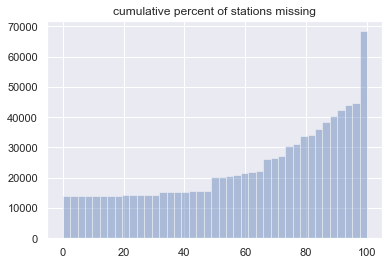

In [43]:
# Plot the number of stations (y-axis) agiast the proportion of stations missing rain data (x-axis)
sns.distplot((1 - circle_data.num_notna/circle_data.num) * 100, kde=False, hist_kws={'cumulative': True}).set_title('cumulative percent of stations missing')


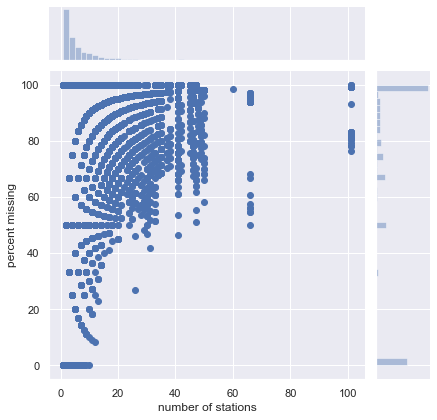

In [44]:
# Plot the relationship between the nuber of stations and the proportion of stations missing Rain data
sns.jointplot(circle_data.num, (1 - circle_data.num_notna/circle_data.num) * 100).set_axis_labels("number of stations", 'percent missing')

#### Percent of circles where all stations are missing data

In [45]:
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

34.19067115075303

In [46]:
circle_data.c_rain.value_counts(dropna = False)

NaN      34530
False    23847
True     10013
Name: c_rain, dtype: int64

#### Percent of circles where no stations are missing data

In [47]:
((circle_data.num_notna == circle_data.num) & (circle_data.num > 0)).sum() / len(circle_data) * 100

20.592191840912413

#### Percent of circles with over half of the stations reporting Rain Data

In [48]:
((circle_data.num_notna / circle_data.num) >= 0.5).sum() / len(circle_data) * 100

29.76604766778769

## The number of stations per circle broken down by ecosystem. 
The two ecosystems calssification are ecosystem (as defined by usgs) and nlcd code

The prefixes "e_" and "n_", which is same ecosystem and same nlcd code, respectfully

In [49]:
# The breakdown of stations with the same nlcd code 
circle_data.n_num.describe()

count    68390.000000
mean         2.174675
std          3.956987
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         52.000000
Name: n_num, dtype: float64

In [50]:
# The breakdown of stations with the same ecosystem
circle_data.e_num.describe()

count    68390.000000
mean         1.517225
std          2.816323
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         26.000000
Name: e_num, dtype: float64

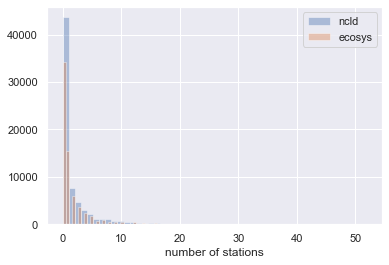

In [51]:
# The number of stations that share the same ncld or ecosys with their circle
sns.distplot(circle_data.n_num, kde=False)
ax = sns.distplot(circle_data.e_num, kde=False)
ax.set_xlabel("number of stations")
ax.legend(["ncld", "ecosys"])

### The number of stations with rain data in the same ecosystem classifical as the  circle

In [52]:
circle_data.n_num_notna.describe()

count    68390.000000
mean         0.587776
std          1.129538
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         30.000000
Name: n_num_notna, dtype: float64

In [53]:
circle_data.e_num_notna.describe()

count    68390.000000
mean         0.411259
std          0.854528
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         15.000000
Name: e_num_notna, dtype: float64

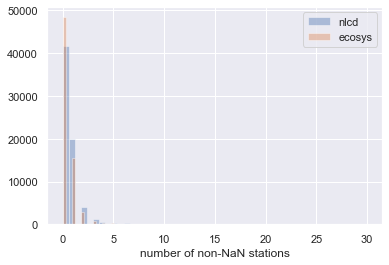

In [54]:
sns.distplot(circle_data.n_num_notna, kde=False)
ax = sns.distplot(circle_data.e_num_notna, kde=False)
ax.set_xlabel("number of non-NaN stations")
ax.legend(["nlcd", "ecosys"])

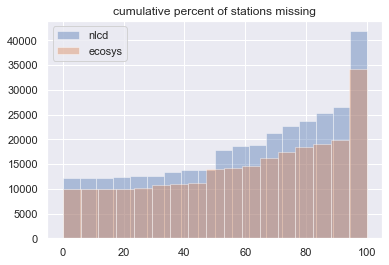

In [55]:
sns.distplot((1 - circle_data.n_num_notna/circle_data.n_num) * 100, kde=False, hist_kws={'cumulative': True})
ax = sns.distplot((1 - circle_data.e_num_notna/circle_data.e_num) * 100, kde=False, hist_kws={'cumulative': True})
ax.set_title('cumulative percent of stations missing')
ax.legend(["nlcd", "ecosys"])

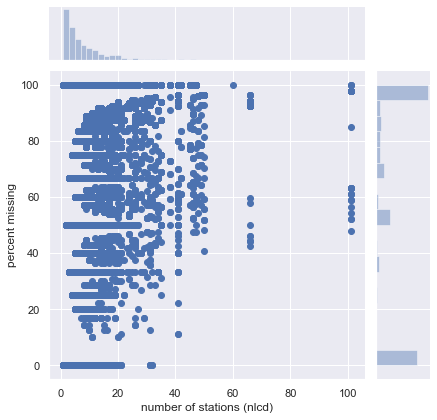

In [56]:
sns.jointplot(circle_data.num, (1 - circle_data.n_num_notna/circle_data.n_num) * 100).set_axis_labels("number of stations (nlcd)", 'percent missing')

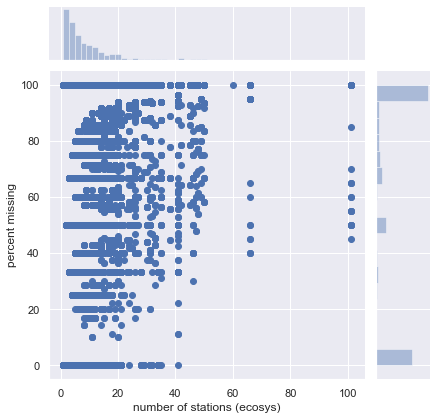

In [57]:
sns.jointplot(circle_data.num, (1 - circle_data.e_num_notna/circle_data.e_num) * 100).set_axis_labels("number of stations (ecosys)", 'percent missing')

#### Percent of circles where all stations are missing data

In [58]:
(circle_data.n_num_notna == 0).sum() / len(circle_data) * 100

60.91387629770434

In [59]:
(circle_data.e_num_notna == 0).sum() / len(circle_data) * 100

70.79690013159818

#### Percent of circles where no stations are missing data

In [60]:
((circle_data.n_num_notna == circle_data.n_num) & (circle_data.n_num > 0)).sum() / len(circle_data) * 100

17.761368621143443

In [61]:
((circle_data.e_num_notna == circle_data.e_num) & (circle_data.e_num > 0)).sum() / len(circle_data) * 100

14.423161280889019

#### Percent of circles with less than half of stations missing

In [62]:
((circle_data.n_num_notna / circle_data.n_num) >= 0.5).sum() / len(circle_data) * 100

26.082760637520103

In [63]:
((circle_data.e_num_notna / circle_data.e_num) >= 0.5).sum() / len(circle_data) * 100

20.381634741921335

## Location, Location, Location
The next section will focus in on the stations closest to the cbc circles by distance

#### What percent of circles had the closest station missing rain data (NaN)?

In [64]:
circle_data.rain_closest.isna().sum() / len(circle_data) * 100

65.28001169761662

#### What percent had the average value of the reference stations differ from the closest station's value (ignoring NaNs)?

In [65]:
# Use kleene logical indexing to skip over NAs
(circle_data.rain_closest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.07164790174002046

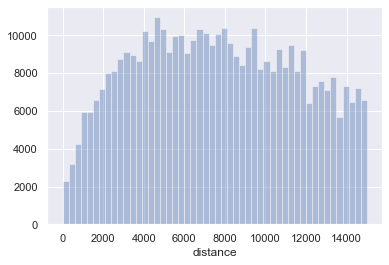

In [66]:
sns.distplot(prcp_data.distance, kde=False)

## Elevation, Elevation, Elevation
The next section will look at stations with the closest elivation

#### What percent of circles had the lowest station as NaN?

In [67]:
circle_data.rain_lowest.isna().sum() / len(circle_data) * 100

65.79032022225472

#### What percent had the average value differ from the lowest value (ignoring NaNs)?

In [68]:
# Use kleene logical indexing to skip over NAs
(circle_data.rain_lowest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.07895891212165522

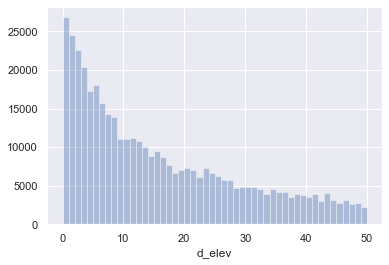

In [69]:
sns.distplot(prcp_data.d_elev, kde=False)

In [70]:
circle_data.consensus.value_counts(dropna = False)

False    30258
NaN      25962
True     12170
Name: consensus, dtype: Int64

## Consensus of Stations
We use `4 * p(1-p)` to estiamte the "disagreement" amongst stations: this value ranges from `0` (all in agrement) to `1` (evenly split)  
(here, `p` is the fraction of non-NaN stations that are `True` for rain)

### All Stations

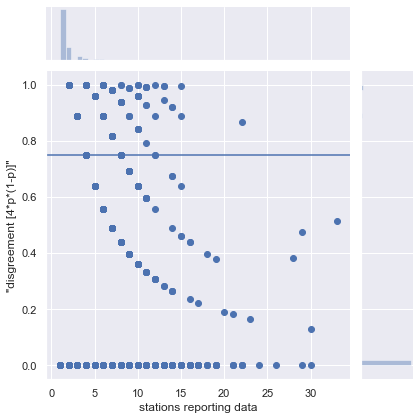

In [71]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p))
p.set_axis_labels("stations reporting data", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

### What percent do not meet our dissagreement threshold?

In [72]:
# Breaking this down a bit for easy of readability 

# circle_data.consensus is na when p (the proportion of staions for a circle reporting rain) is NA OR p is not 
# meeting the AGREEMENT Threshold 

# circle_data.p is NOT na when a circle has at least one station reporting rain data 

# PUTTING IT TOGETHER - The below line is the percent of circles who had at least one station 
# reporting but those stations could not agree
(circle_data.consensus.isna() & circle_data.p.notna()).sum() / len(circle_data) * 100

3.7710191548472003

### Ecosystems

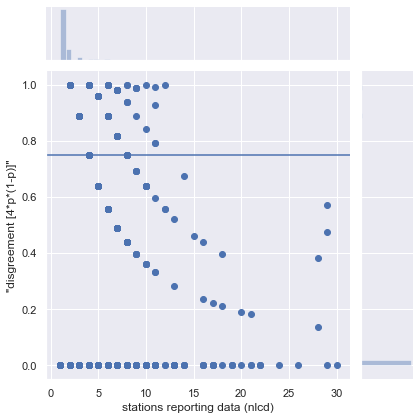

In [73]:
# Agreement Plot for Stations that share ncld codes with their circles 
p = sns.jointplot(circle_data.n_num_notna, 4 * circle_data.n_p * (1 - circle_data.n_p))
p.set_axis_labels("stations reporting data (nlcd)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

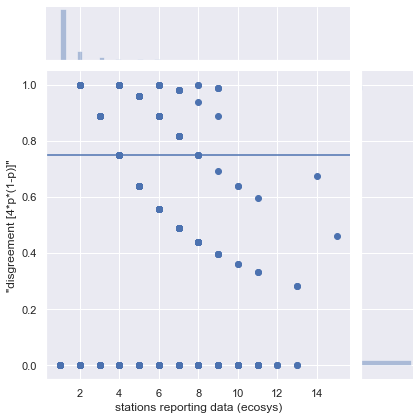

In [74]:
# Agreement Plot for Stations that share ecosys classification with their circles 
p = sns.jointplot(circle_data.e_num_notna, 4 * circle_data.e_p * (1 - circle_data.e_p))
p.set_axis_labels("stations reporting data (ecosys)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

#### What percent do not meet our dissagreement threshold?

In [75]:
# The below line counts the percentage of circles who had at least one station reporting with the same nlcd code
# but did not meet the agreement threshold
(circle_data.n_consensus.isna() & circle_data.n_p.notna()).sum() / len(circle_data) * 100

1.7692645123556074

In [76]:
# The below line counts the percentage of circles who had at least one station reporting with the same ecosys classifier
# but did not meet the agreement threshold
(circle_data.e_consensus.isna() & circle_data.e_p.notna()).sum() / len(circle_data) * 100


1.1419798216113468

### Consensus Breakdown by Circle Rain Reporting

In [77]:
# The number and percentage  of circles that reported Rain, No Rain or are NA 
print("The Count of Circles Reproting Rain:")
print(circle_data.c_rain.value_counts(dropna = False))
print("The Percentage of Circles Reproting Rain:")
print(circle_data.c_rain.value_counts(dropna = False, normalize = True) * 100)

The Count of Circles Reproting Rain:
NaN      34530
False    23847
True     10013
Name: c_rain, dtype: int64
The Percentage of Circles Reproting Rain:
NaN      50.489838
False    34.869133
True     14.641029
Name: c_rain, dtype: float64


#### Break Down of Concensus for Circles that reported True for Rain

In [78]:

print("Rain Data Consensus Amoung All Stations where the Circle Reported Rain:")
print(circle_data.loc[circle_data['c_rain'] == True].consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == True].consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == True]) * 100))

print("")

print("Rain Data Amoung Closest Stations where the Circle Reported Rain:")
print(circle_data.loc[circle_data['c_rain'] == True].rain_closest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == True].rain_closest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == True]) * 100))

print("")

print("Rain Data Amoung Closest in Elivation Stations where the Circle Reported Rain:")
print(circle_data.loc[circle_data['c_rain'] == True].rain_lowest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == True].rain_lowest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == True]) * 100))

print("")

print("Rain Data Consensus Amoung Stations with the same nlcd code where the Circle Reported Rain:")
print(circle_data.loc[circle_data['c_rain'] == True].n_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == True].n_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == True]) * 100))

print("")

print("Rain Data Consensus Amoung Stations with the same ecosys classification where the Circle Reported Rain:")
print(circle_data.loc[circle_data['c_rain'] == True].e_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == True].e_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == True]) * 100))




Rain Data Consensus Amoung All Stations where the Circle Reported Rain:
NaN      4638
True     3709
False    1666
Name: consensus, dtype: Int64
^^ with Percentage:
NaN      46.319784
True     37.041846
False    16.638370
Name: consensus, dtype: float64

Rain Data Consensus Amoung Closest Stations where the Circle Reported Rain:
NaN      7826
True     1425
False     762
Name: rain_closest, dtype: Int64
^^ with Percentage:
NaN      78.158394
True     14.231499
False     7.610107
Name: rain_closest, dtype: float64

Rain Data Consensus Amoung Closest in Elivation Stations where the Circle Reported Rain:
NaN      7854
True     1406
False     753
Name: rain_lowest, dtype: Int64
^^ with Percentage:
NaN      78.438031
True     14.041746
False     7.520224
Name: rain_lowest, dtype: float64

Rain Data Consensus Amoung Stations with the same nlcd code where the Circle Reported Rain:
NaN      6697
True     2267
False    1049
Name: n_consensus, dtype: Int64
^^ with Percentage:
NaN      66.883052
Tr

#### Break Down of Concensus for Circles that reported False for Rain

In [79]:

print("Rain Data Consensus Amoung All Stations where the Circle did NOT Report Rain:")
print(circle_data.loc[circle_data['c_rain'] == False].consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == False].consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == False]) * 100))

print("Rain Data Amoung Closest Stations where the Circle did NOT Report Rain:")
print(circle_data.loc[circle_data['c_rain'] == False].rain_closest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == False].rain_closest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == False]) * 100))

print("Rain Data Amoung Closest in Elivation Stations where the Circle did NOT Report Rain:")
print(circle_data.loc[circle_data['c_rain'] == False].rain_lowest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == False].rain_lowest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == False]) * 100))

print("Rain Data Consensus Amoung Stations with the same nlcd code where the Circle did NOT Report Rain:")
print(circle_data.loc[circle_data['c_rain'] == False].n_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == False].n_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == False]) * 100))

print("Rain Data Consensus Amoung Stations with the same ecosys classification where the Circle did NOT Report Rain:")
print(circle_data.loc[circle_data['c_rain'] == False].e_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_rain'] == False].e_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_rain'] == False]) * 100))




Rain Data Consensus Amoung All Stations where the Circle did NOT Report Rain:
False    10533
NaN       9832
True      3482
Name: consensus, dtype: Int64
^^ with Percentage:
False    44.169078
NaN      41.229505
True     14.601417
Name: consensus, dtype: float64
Rain Data Consensus Amoung Closest Stations where the Circle did NOT Report Rain:
NaN      17761
False     4460
True      1626
Name: rain_closest, dtype: Int64
^^ with Percentage:
NaN      74.478970
False    18.702562
True      6.818468
Name: rain_closest, dtype: float64
Rain Data Consensus Amoung Closest in Elivation Stations where the Circle did NOT Report Rain:
NaN      17864
False     4427
True      1556
Name: rain_lowest, dtype: Int64
^^ with Percentage:
NaN      74.91089
False    18.56418
True      6.52493
Name: rain_lowest, dtype: float64
Rain Data Consensus Amoung Stations with the same nlcd code where the Circle did NOT Report Rain:
NaN      14820
False     6850
True      2177
Name: n_consensus, dtype: Int64
^^ with Per

## The Missing Station and Circle Data

In [80]:
# Create a series indicating if a circle is missing weather data
circle_data_na_circle_idx = circle_data.c_rain.isna()

### Percent of circles with missing rain observation

In [81]:
circle_data_na_circle_idx.sum() / len(circle_data) * 100

50.48983769556953

In [86]:
circle_data.head()

c_name                     ui country_state  \
c_id    count_date                                                        
87ymwsn 1968-12-26  Kaua'i: Waimea  22.0833-159.6667_1969         US-HI   
87ysunb 1971-12-27  Kaua'i: Lihu'e  21.9667-159.4333_1972         US-HI   
        1972-12-17  Kaua'i: Lihu'e  21.9667-159.4333_1973         US-HI   
        1973-12-16  Kaua'i: Lihu'e  21.9667-159.4333_1974         US-HI   
        1974-12-15  Kaua'i: Lihu'e  21.9667-159.4333_1975         US-HI   

                      c_lat     c_lon c_rain  num  num_notna  num_true  e_num  \
c_id    count_date                                                              
87ymwsn 1968-12-26  22.0833 -159.6667  False    1          0         0      0   
87ysunb 1971-12-27  21.9667 -159.4333   True   13          0         0      0   
        1972-12-17  21.9667 -159.4333   True   13          0         0      0   
        1973-12-16  21.9667 -159.4333    NaN   13          2         0      0   
        1974-12-15  21.9667 -159.4333   True   13          0         0      0   

                    ...    p  e_p  n_p  rain_closest  rain_closest_notna  \
c_id    count_date  ...                                                    
87ymwsn 1968-12-26  ...  NaN  NaN  NaN          <NA>                <NA>   
87ysunb 1971-12-27  ...  NaN  NaN  NaN          <NA>                <NA>   
        1972-12-17  ...  NaN  NaN  NaN          <NA>                <NA>   
        1973-12-16  ...  0.0  NaN  NaN          <NA>               False   
        1974-12-15  ...  NaN  NaN  NaN          <NA>                <NA>   

                    rain_lowest  rain_lowest_notna  consensus  e_consensus  \
c_id    count_date                                                           
87ymwsn 1968-12-26         <NA>               <NA>       <NA>         <NA>   
87ysunb 1971-12-27         <NA>               <NA>       <NA>         <NA>   
        1972-12-17         <NA>               <NA>       <NA>         <NA>   
        1973-12-16         <NA>              False      False         <NA>   
        1974-12-15         <NA>               <NA>       <NA>         <NA>   

                    n_consensus  
c_id    count_date               
87ymwsn 1968-12-26         <NA>  
87ysunb 1971-12-27         <NA>  
        1972-12-17         <NA>  
        1973-12-16         <NA>  
        1974-12-15         <NA>  

[5 rows x 25 columns]

In [82]:
circle_data.shape

(68390, 25)

In [85]:
circle_data['ui'].nunique()

68390

### Count of circles with missing rain observation

In [81]:
print("Circles with missing Rain Data: ")
print(circle_data_na_circle_idx.sum())
print("Circles with NO missing Rain Data: ")
print(len(circle_data) - circle_data_na_circle_idx.sum())

Circles with missing Rain Data: 
34530
Circles with NO missing Rain Data: 
33860


### Percent of circles with both volunteer and all station data are missing

In [82]:
# joint
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / len(circle_data) * 100

15.454013744699518

In [83]:
# conditional 
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / circle_data_na_circle_idx.sum() * 100

30.60816681146829

In [84]:
# population
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

34.19067115075303

### Correlation between the two

In [85]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna == 0))
g, p

(397.49296252269755, 1.9350377138866115e-88)

If the circle is missing data, it is much more likely that all other stations will too, when compared to the general population

#### Count and Percent of Stations Reporting if the Circle Reported Rain Data

In [86]:
print("Stations with missing Rain Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna == 0)].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna == 0)].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Stations with NO missing Rain Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna != 0)].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna != 0)].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Stations with missing Rain Data IF the the Circle is Reporting:
12814
37.84406379208506
Stations with NO missing Rain Data IF the Circle is Reporting: 
21046
62.15593620791494


### Percent of circles with both volunteer and the closest station data are missing

In [87]:
# joint
(circle_data_na_circle_idx & circle_data.rain_closest.isna()).sum()  / len(circle_data) * 100

27.86664717063898

In [88]:
# conditional 
(circle_data_na_circle_idx & circle_data.rain_closest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

55.192586156964964

In [89]:
# population
circle_data.rain_closest.isna().sum() / len(circle_data) * 100

65.28001169761662

In [90]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.rain_closest.isna()))
g, p

(3130.245692881584, 0.0)

If the circle is missing data, it is much **less** likely that the closest station will have missing data, when compared to the general population

#### Count and Percent of Closest Stations Reporting if the Circle Reported Rain Data

In [91]:
print("Closest Stations with missing Rain Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.rain_closest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.rain_closest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Closest Stations with NO missing Rain Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.rain_closest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.rain_closest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Closest Stations with missing Rain Data IF the the Circle is Reporting:
25587
75.56704075605434
Closest Stations with NO missing Rain Data IF the Circle is Reporting: 
8273
24.43295924394566


### Percent of circles with both volunteer and the lowest station data are missing

In [92]:
# joint
(circle_data_na_circle_idx & circle_data.rain_lowest.isna()).sum()  / len(circle_data) * 100

28.185407223278258

In [93]:
# conditional 
(circle_data_na_circle_idx & circle_data.rain_lowest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

55.82392122791775

In [94]:
# population
circle_data.rain_lowest.isna().sum() / len(circle_data) * 100

65.79032022225472

In [95]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.rain_lowest.isna()))
g, p

(3077.0995889506353, 0.0)

If the circle is missing data, it is much **less** likely that the lowest station will have missing data, when compared to the general population

#### Count and Percent of Closest Elivation Stations Reporting if the Circle Reported Rain Data

In [96]:
print("Closest Elivation Stations with missing Rain Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.rain_lowest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.rain_lowest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Closest Elivation Stations with NO missing Rain Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.rain_lowest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.rain_lowest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Closest Elivation Stations with missing Rain Data IF the the Circle is Reporting:
25718
75.95392793857059
Closest Elivation Stations with NO missing Rain Data IF the Circle is Reporting: 
8142
24.046072061429417


### Number of stations for circles with missing data

In [97]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna)
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(2412.6366363638845, 0.0)

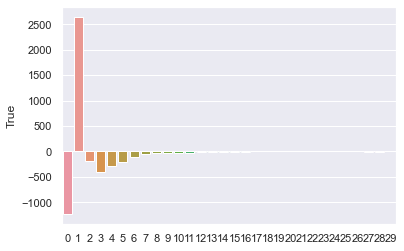

In [98]:
sns.barplot(np.arange(expctd.shape[1]), actl.loc[True] - expctd[1, :])

it looks like the circle being missing implies that there is only one non-na station?

### Disagreement

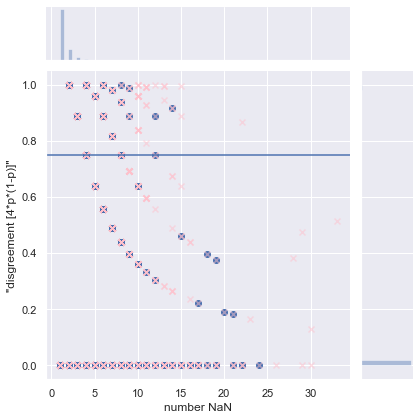

In [99]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.loc[circle_data_na_circle_idx, 'num_notna'], 
                  4 * circle_data.loc[circle_data_na_circle_idx, 'p'] * (1 - circle_data.loc[circle_data_na_circle_idx, 'p']))
p.ax_joint.scatter(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p), color='pink', marker='x', alpha=0.5)
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

### What percent do not meet our dissagreement threshold?

In [100]:
# joint
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / len(circle_data) * 100

16.80362626114929

In [101]:
# conditional
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / circle_data_na_circle_idx.sum() * 100

33.28120474949319

In [102]:
# population
circle_data.consensus.isna().sum() / len(circle_data) * 100

37.96169030560023

In [103]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.consensus.isna())
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(648.3504089430816, 5.103468202483568e-143)

In [104]:
actl - expctd

consensus,False,True
c_rain,,
False,-1616.171663,1616.171663
True,1616.171663,-1616.171663


Missing your rain data imples the stations are more likely to consense

# The Truth: Reference Stations Vs Other Reference Station Data

This just station data all by itself (station data vs station data)

Testing to see if there is that much difference between the "truth" from the different station metrics (ie, consensus, consensus amongst the same ecosystem)

How often does it rain?

In [105]:
# Proportion of circle's stations with consensus reporting True / count of all circlce's stations with a consenseus 
circle_data.consensus.sum()/ circle_data.consensus.count()

0.28683887998491564

### Location & Consensus

In [106]:
# Cross tabs of the closest station to a circle vs the consenting stations 
pd.crosstab(circle_data.consensus, circle_data.rain_closest_notna, margins = True)

rain_closest_notna,False,True,All
consensus,,,
False,30235,23,30258
True,26,12144,12170
All,30261,12167,42428


In [107]:
# Cross tabs of the closest station in elivation to a circle vs the consenting stations 
pd.crosstab(circle_data.consensus, circle_data.rain_lowest_notna, margins = True)

rain_lowest_notna,False,True,All
consensus,,,
False,30176,27,30203
True,27,12037,12064
All,30203,12064,42267


In [108]:
# Cross tabs of the closest station to a circle vs the station with the closest elivation
pd.crosstab(circle_data.rain_closest_notna, circle_data.rain_lowest_notna, margins = True)

rain_lowest_notna,False,True,All
rain_closest_notna,,,
False,30903,568,31471
True,567,12808,13375
All,31470,13376,44846


### Ecosystem Consensus

In [109]:
# Crosstable of stations with consensus vs stations with nlcd consensus 
pd.crosstab(circle_data.consensus, circle_data.n_consensus, margins = True)

n_consensus,False,True,All
consensus,,,
False,17810,2,17812
True,3,7014,7017
All,17813,7016,24829


In [110]:
# Crosstabs  of stations with consensus vs stations with ecosys consensus
pd.crosstab(circle_data.consensus, circle_data.e_consensus, margins = True)

e_consensus,False,True,All
consensus,,,
False,13327,2,13329
True,3,5108,5111
All,13330,5110,18440


In [111]:
pd.crosstab(circle_data.n_consensus, circle_data.e_consensus, margins = True)

e_consensus,False,True,All
n_consensus,,,
False,13581,1,13582
True,0,5337,5337
All,13581,5338,18919


 ### Did just one station see rain?

In [112]:
# Cross tabes of the rain reported by the closest station and if any reference station said it rained
pd.crosstab(circle_data.rain_closest_notna, circle_data.num_true > 0, margins = True)

num_true,False,True,All
rain_closest_notna,,,
False,30100,1426,31526
True,0,13481,13481
All,30100,14907,45007


In [113]:
# Crosstabs of the rain reported by the closest station in elivation and if any reference station said it rained
pd.crosstab(circle_data.rain_lowest_notna, circle_data.num_true > 0, margins = True)


num_true,False,True,All
rain_lowest_notna,,,
False,30045,1425,31470
True,0,13376,13376
All,30045,14801,44846


In [114]:
# Crosstabs of the stations resporting consensus vs ANY reference station that reported rain
pd.crosstab(circle_data.consensus, circle_data.num_true > 0, margins = True)



num_true,False,True,All
consensus,,,
False,30100,158,30258
True,0,12170,12170
All,30100,12328,42428


In [115]:
# Crosstabs of the stations resporting consensus vs ANY NLCD MATCHING reference station that reported rain
pd.crosstab(circle_data.consensus, circle_data.n_num_true > 0, margins = True)

n_num_true,False,True,All
consensus,,,
False,30150,108,30258
True,5127,7043,12170
All,35277,7151,42428


In [116]:
# Crosstabs of the stations resporting consensus vs ANY ECOSYS MATCHING reference station that reported rain
pd.crosstab(circle_data.consensus, circle_data.e_num_true > 0, margins = True)

e_num_true,False,True,All
consensus,,,
False,30186,72,30258
True,7031,5139,12170
All,37217,5211,42428


# Circle v Station: The Final Determination on If Volenteers are Reliable

In [117]:
def crosstab_metrics(actl):
    # accuracy
    acc = actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()
    # precision
    pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
    # recall
    re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
    # F1
    f1 = 2 * pr * re / (pr + re)
    
    print(f"accuracy:  {acc*100:.2f}%")
    print(f"precision: {pr*100:.2f}%")
    print(f"recall:    {re*100:.2f}%")
    print(f"F1:        {f1*100:.2f}%")
    
#     return (acc, pr, re, f1)

### Based on the stations' consensus

In [118]:
actl = pd.crosstab(circle_data.consensus, circle_data.c_rain)
actl

c_rain,False,True
consensus,,
False,10533,1666
True,3482,3709


In [121]:
crosstab_metrics(actl)

accuracy:  73.45%
precision: 69.00%
recall:    51.58%
F1:        59.03%


### Based on the closest station

In [122]:
actl = pd.crosstab(circle_data.rain_closest_notna, circle_data.c_rain)
actl

c_rain,False,True
rain_closest_notna,,
False,11093,1923
True,4036,3994


In [123]:
crosstab_metrics(actl)

accuracy:  71.69%
precision: 67.50%
recall:    49.74%
F1:        57.27%


### Based on the lowest station

In [124]:
actl = pd.crosstab(circle_data.rain_lowest_notna, circle_data.c_rain)
actl

c_rain,False,True
rain_lowest_notna,,
False,11048,1932
True,4022,3945


In [125]:
crosstab_metrics(actl)

accuracy:  71.58%
precision: 67.13%
recall:    49.52%
F1:        56.99%


### Based on the nlcd consensus

In [126]:
actl = pd.crosstab(circle_data.n_consensus, circle_data.c_rain)
actl

c_rain,False,True
n_consensus,,
False,6850,1049
True,2177,2267


In [127]:
crosstab_metrics(actl)

accuracy:  73.86%
precision: 68.37%
recall:    51.01%
F1:        58.43%


### Based on the ecosys consensus

In [128]:
actl = pd.crosstab(circle_data.e_consensus, circle_data.c_rain)
actl

c_rain,False,True
e_consensus,,
False,5397,784
True,1688,1703


In [129]:
crosstab_metrics(actl)

accuracy:  74.17%
precision: 68.48%
recall:    50.22%
F1:        57.94%


### Did at least one station aggree?

In [130]:
actl = pd.crosstab(circle_data.num_true >= 1, circle_data.c_rain)
actl

c_rain,False,True
num_true,,
False,19162,5720
True,4685,4293


In [131]:
crosstab_metrics(actl)

accuracy:  69.27%
precision: 42.87%
recall:    47.82%
F1:        45.21%
